# Bio Signal Workshop 2022

Submission by Gaffar and Tobias

## Introduction

During the workshop, our task was to
- Design an experiment to measure different cognitive load levels
- Conduct the experiment and collect data from all participants of our workshop group
- Preprocess and clean the data
- Extract features for machine learning
- Classify different cognitive load levels via machine learning
- [Create an online system prototype]

Throughout the course, we were working with Unicorn Hybrid Black devices. 

<img src="https://www.unicorn-bi.com/wp-content/uploads/2018/12/unicorn-newslide-05.jpg" alt="Unicorn EEG" title="Unicorn EEG" width="250"/>

These EEGs offer eight electrodes, sampled with 250 Hz per channel.

A layout of the electrodes is shown two cells below.

In [33]:
import glob
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import mne
import numpy as np
import pandas as pd
import pyxdf

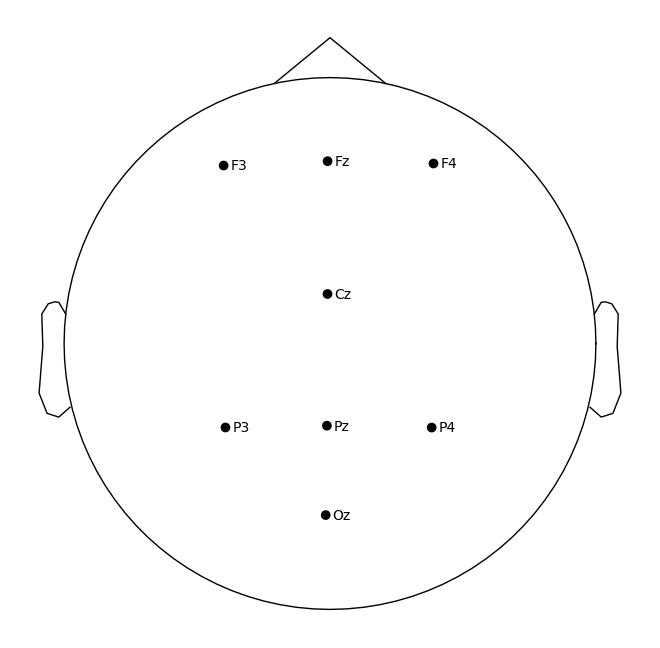

In [34]:
mont1020 = mne.channels.make_standard_montage('standard_1020')
kept_channels = ['Fz', 'Cz', 'Pz', 'Oz', 'F3', 'F4', 'P3', 'P4']
ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_new = mont1020.copy()

# Keep only the desired channels
mont1020_new.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]

# Keep the first three rows as they are the fiducial points information
mont1020_new.dig = mont1020.dig[0:3]+kept_channel_info
mont1020_new.plot();

## Experiment

### General description

The experiment is designed to measure cognitive load by means of multitasking with increasing difficulty.

It comprises y=3 trials with 3 stages each. The three trials start automatically after each other.

Per stage, the duration is x=40 seconds 

Between the stages participants take a break of p=40 seconds. 

An automatic timer tracks these breaks and counts down between the stages.

Randomization of the stages ensures external validity.

We make use of a Unity environment which looks like this:

![CL Experiment](preview_cl.PNG)

### Experiment summary
* We ensure a quiet environment with only two persons in the room: subject and experimenter
* To minimize signal noise,
  * participants are told to move as little as possible
  * experimenter clicks the answers which the participants speak out loud
* We record Baseline of x=40 seconds duration. During this period, participants look outside the window.
* The tasks consist of three inclusive difficulty levels and also last x=40 seconds each: 
  * trace ball 
  * trace ball and calculate sum 
  * trace ball and calculate sum and track turning wheel
* Participant make y=3 trials (1 trial = all three difficulty levels in a row)
* between the trials participants take a break of p=40 seconds.

### Software workflow
* Start unicorn suite hybrid black
* Connect EEG (see MAC address on the back side of the device, e.g. UN-2021.12.35)
* Start Unicorn recorder and check signal visually
* Start Unity experiment software
* Start Unicorn lsl
* Define Stream Name as "eeg"
* Start Stream
* Start LSL Recorder
* Save "eeg" and "markers" streams (baseline as own file and experiment as own file)

## Data preparation

In [35]:
# Setup logging
# Set to ERROR to suppress warnings about empty streams

# Background: 
# Some recordings contain empty streams of length 0 (additionally to "eeg" and "markers")
# A warning occurs when reading them via pyxdf.
# We filter these streams after loading the data by checking for the stream length.

import logging
logFormatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

In [36]:
# Load data 
# The files can be separated by the Session ID
# Files with session identifier S001 contain baseline recordings
# Files with session identifier S002 contain experiment recordings

def load_data(path: str):
    tmp = []
    for file in glob.glob(path, recursive=True):
        tmp.append(file)
    return tmp


# load baseline file names
baseline_list = load_data('data/**/*S001*.xdf')
current_baseline_list = [x for x in baseline_list if 'Tobias' in x]
print(current_baseline_list)

# load experiment file names
experiment_list = load_data('data/**/*S002*.xdf')
current_experiment_list = [x for x in experiment_list if 'Tobias' in x]
print(current_experiment_list)


['data/gme2022/sub-Tobias/ses-S001/eeg/sub-Tobias_ses-S001_task-Default_run-001_eeg.xdf']
['data/gme2022/sub-Tobias/ses-S002/eeg/sub-Tobias_ses-S002_task-Default_run-001_eeg.xdf']


In [37]:
# Read baseline function

def read_baseline(current_baseline_list):
    """ Convert the data into a RawArray Object.
        To this end a "info" object has to be created, 

    Parameters
    ----------
    current_baseline_list : list of strings
        The list of filenames to read.

    Returns
    -------
    current_baseline_mne_list : list of RawArrays
        Loaded data in format of the MNE toolkit.
    """

    current_baseline_mne_list = []

    sfreq = 250
    info = mne.create_info(8, sfreq, ["eeg"] * 8)

    for baseline in current_baseline_list:
        streams, _ = pyxdf.load_xdf(baseline)
        try:
            data = streams[1]["time_series"].T[:8]
        except AttributeError:
            # some recordings miss the marker channel
            # in this case "eeg" 
            data = streams[0]["time_series"].T[:8]
        raw = mne.io.RawArray(data, info, verbose=False)
        raw = raw.crop(tmin=1, tmax=41)
        current_baseline_mne_list.append(raw)
    return current_baseline_mne_list

# check if the function works as expected by performing a load
current_baseline_mne_list = read_baseline(current_baseline_list)
print(current_baseline_mne_list)

[<RawArray | 8 x 10001 (40.0 s), ~638 kB, data loaded>]


In [41]:
# read trials

def read_trails(current_experiment_list: list, current_baseline_list: list) -> dict:
    """ Read all trias and the baseline of one or more subjects.
        Put the converted data into a dictionary with a key for each treatment.

    Parameters
    ----------
    current_experiment_list : list of strings
        The list of experiment filenames to read.
    current_baseline_list : list of strings
        The list of baseline filenames to read.

    Returns
    -------
    trials : dict
        Lists of RawArray MNE Objects of all trials and baselines seperated by their type.
    """

    trials = { 
            'ball': list(),
            'ball+number': list(),
            'ball+number+wheel': list(),
            'baseline': read_baseline(current_baseline_list),
            }

    for experiment in current_experiment_list:

        streams, _ = pyxdf.load_xdf(experiment)

        # The index for the two relevant channels changes for different recordings
        # Determine which is the marker and eeg stream
        marker = -1 
        eeg = -1
        for idx, stream in enumerate(streams):
            if streams[idx]['time_stamps'].shape[0] == 0:
                continue # ignore empty streams
            if stream["info"]["name"] == ["markers"]:
                marker = idx
            elif stream["info"]["name"] == ["eeg"]:
                eeg = idx
            else:
                raise Exception(f"stream info name unknown {stream['info']['name']}")
        if marker == -1 or eeg == -1:
            raise Exception('channels not found') # eeg or marker stream not found
        
        for i in range(0, streams[marker]["time_stamps"].shape[0], 2):
            # Get start and stop markers for relevant events
            event = streams[marker]["time_series"][i][0] # event name as string
            if event in ['Starting Complex Eye Tracking Dashboard', 'Starting Simple Eye Tracking Dashboard', '']:
                continue # ignore irrelevant events
            start = streams[marker]["time_stamps"][i] # start time of relevant event
            stop = streams[marker]["time_stamps"][i+1]

            # collect all data for this event
            data = []
            for j, stamp in enumerate(streams[eeg]["time_stamps"]):
                if start <= stamp and stamp <= stop: 
                    data.append(streams[eeg]["time_series"][j])
            data = np.array(data).T[:8]

            # convert into MNE RawArray object
            sfreq = 250
            info = mne.create_info(8, sfreq, ["eeg"] * 8)
            trial = mne.io.RawArray(data, info, verbose=False)

            # determine correct key/label
            if event == 'Starting Cognitive Load Tasks: Balls True, Numbers False, Wheel False':
                key = 'ball'
            elif event == 'Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel False':
                key = 'ball+number'
            elif event == 'Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel True':
                key = 'ball+number+wheel'
            else:
                print(f"key {event} not defined!")

            trials[key].append(trial)
        
    return trials

# test the function and read current list
trials = read_trails(current_experiment_list, current_baseline_list) 

# Descriptive analysis and preprocessing

We discuss following topics:
* Power line noise
* Bad channels / artifacts
* Baseline correction (BC)

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_1626693/3476390119.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmax=np.inf, fmax=125);


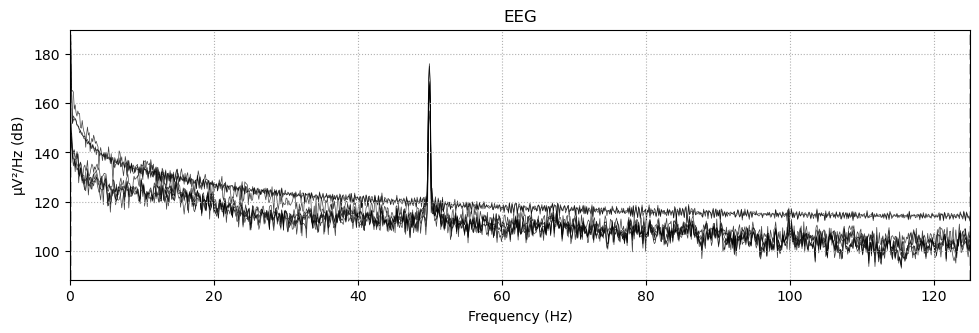

In [43]:
# Plot psd (power spectral density) with power line noise
# The power line noise is the peak at 50 Hz.
# Note that all multiples of 50 Hz (here 100 Hz) are also affected

raw = current_baseline_mne_list[0]
raw.plot_psd(tmax=np.inf, fmax=125);


Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_1626693/1022492995.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_notch.plot_psd(tmax=np.inf, fmax=125);


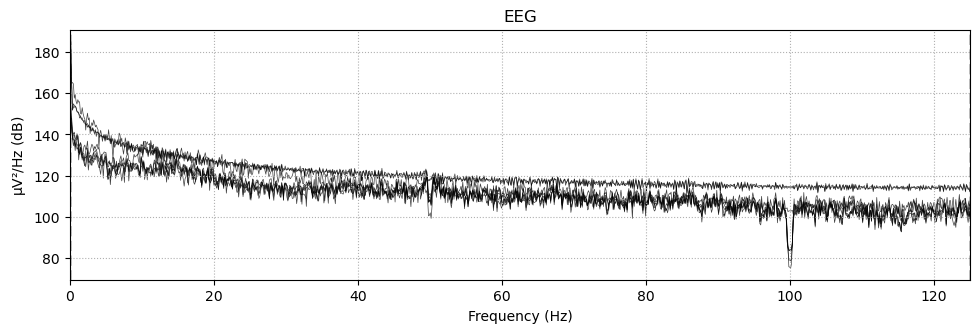

In [42]:
# Filter power line noise and plot psd
# Using the notch filter with an appropriate width (here 0.5) the peaks can me eliminated

freqs = (50, 100)
raw_notch = raw.copy().notch_filter(freqs=freqs, verbose=False, notch_widths=0.5)
raw_notch.plot_psd(tmax=np.inf, fmax=125);


<RawArray | 8 x 10001 (40.0 s), ~638 kB, data loaded>
Setting up band-stop filter from 2 - 60 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 2.00, 60.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.


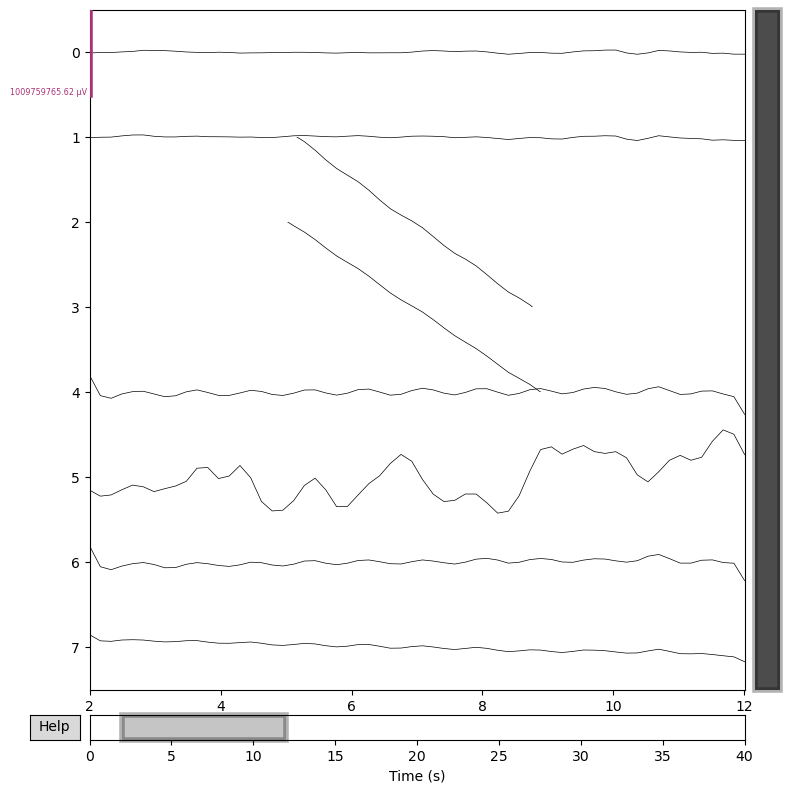

In [10]:
# Show bad channel example
# Notice the missing/skewed values for channel 2 and 3
# It is too long for a blink. Could be related to movement?!

raw = current_baseline_mne_list[0]
print(raw)
raw.plot(scalings='auto', duration=10, start=2, n_channels=8, highpass=60, lowpass=2, clipping='transparent');

<RawArray | 8 x 10001 (40.0 s), ~638 kB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  0     EEG   µV    216116171875.00  216183312500.00  216211109375.00  216238203125.00  216318578125.00
 1  1     EEG   µV    198510406250.00  198623781250.00  198689671875.00  198756906250.00  198883500000.00
 2  2     EEG   µV    343870062500.00  347976343750.00  352415687500.00  357466187500.00  363480875000.00
 3  3     EEG   µV    338257625000.00  342202437500.00  346463937500.00  351243093750.00  356817187500.00
 4  4     EEG   µV    180593703125.00  180760437500.00  181016765625.00  181274718750.00  181453171875.00
 5  5     EEG   µV    158166671875.00  158981171875.00  160792375000.00  161212500000.00  161668484375.00
 6  6     EEG   µV    207878921875.00  208076515625.00  208303781250.00  208533656250.00  208694765625.00
 7  7     EEG   µV    170864078125.00  171176906250.00  171331500000.00  171488765625.00  171841468750.00
Describe:  None


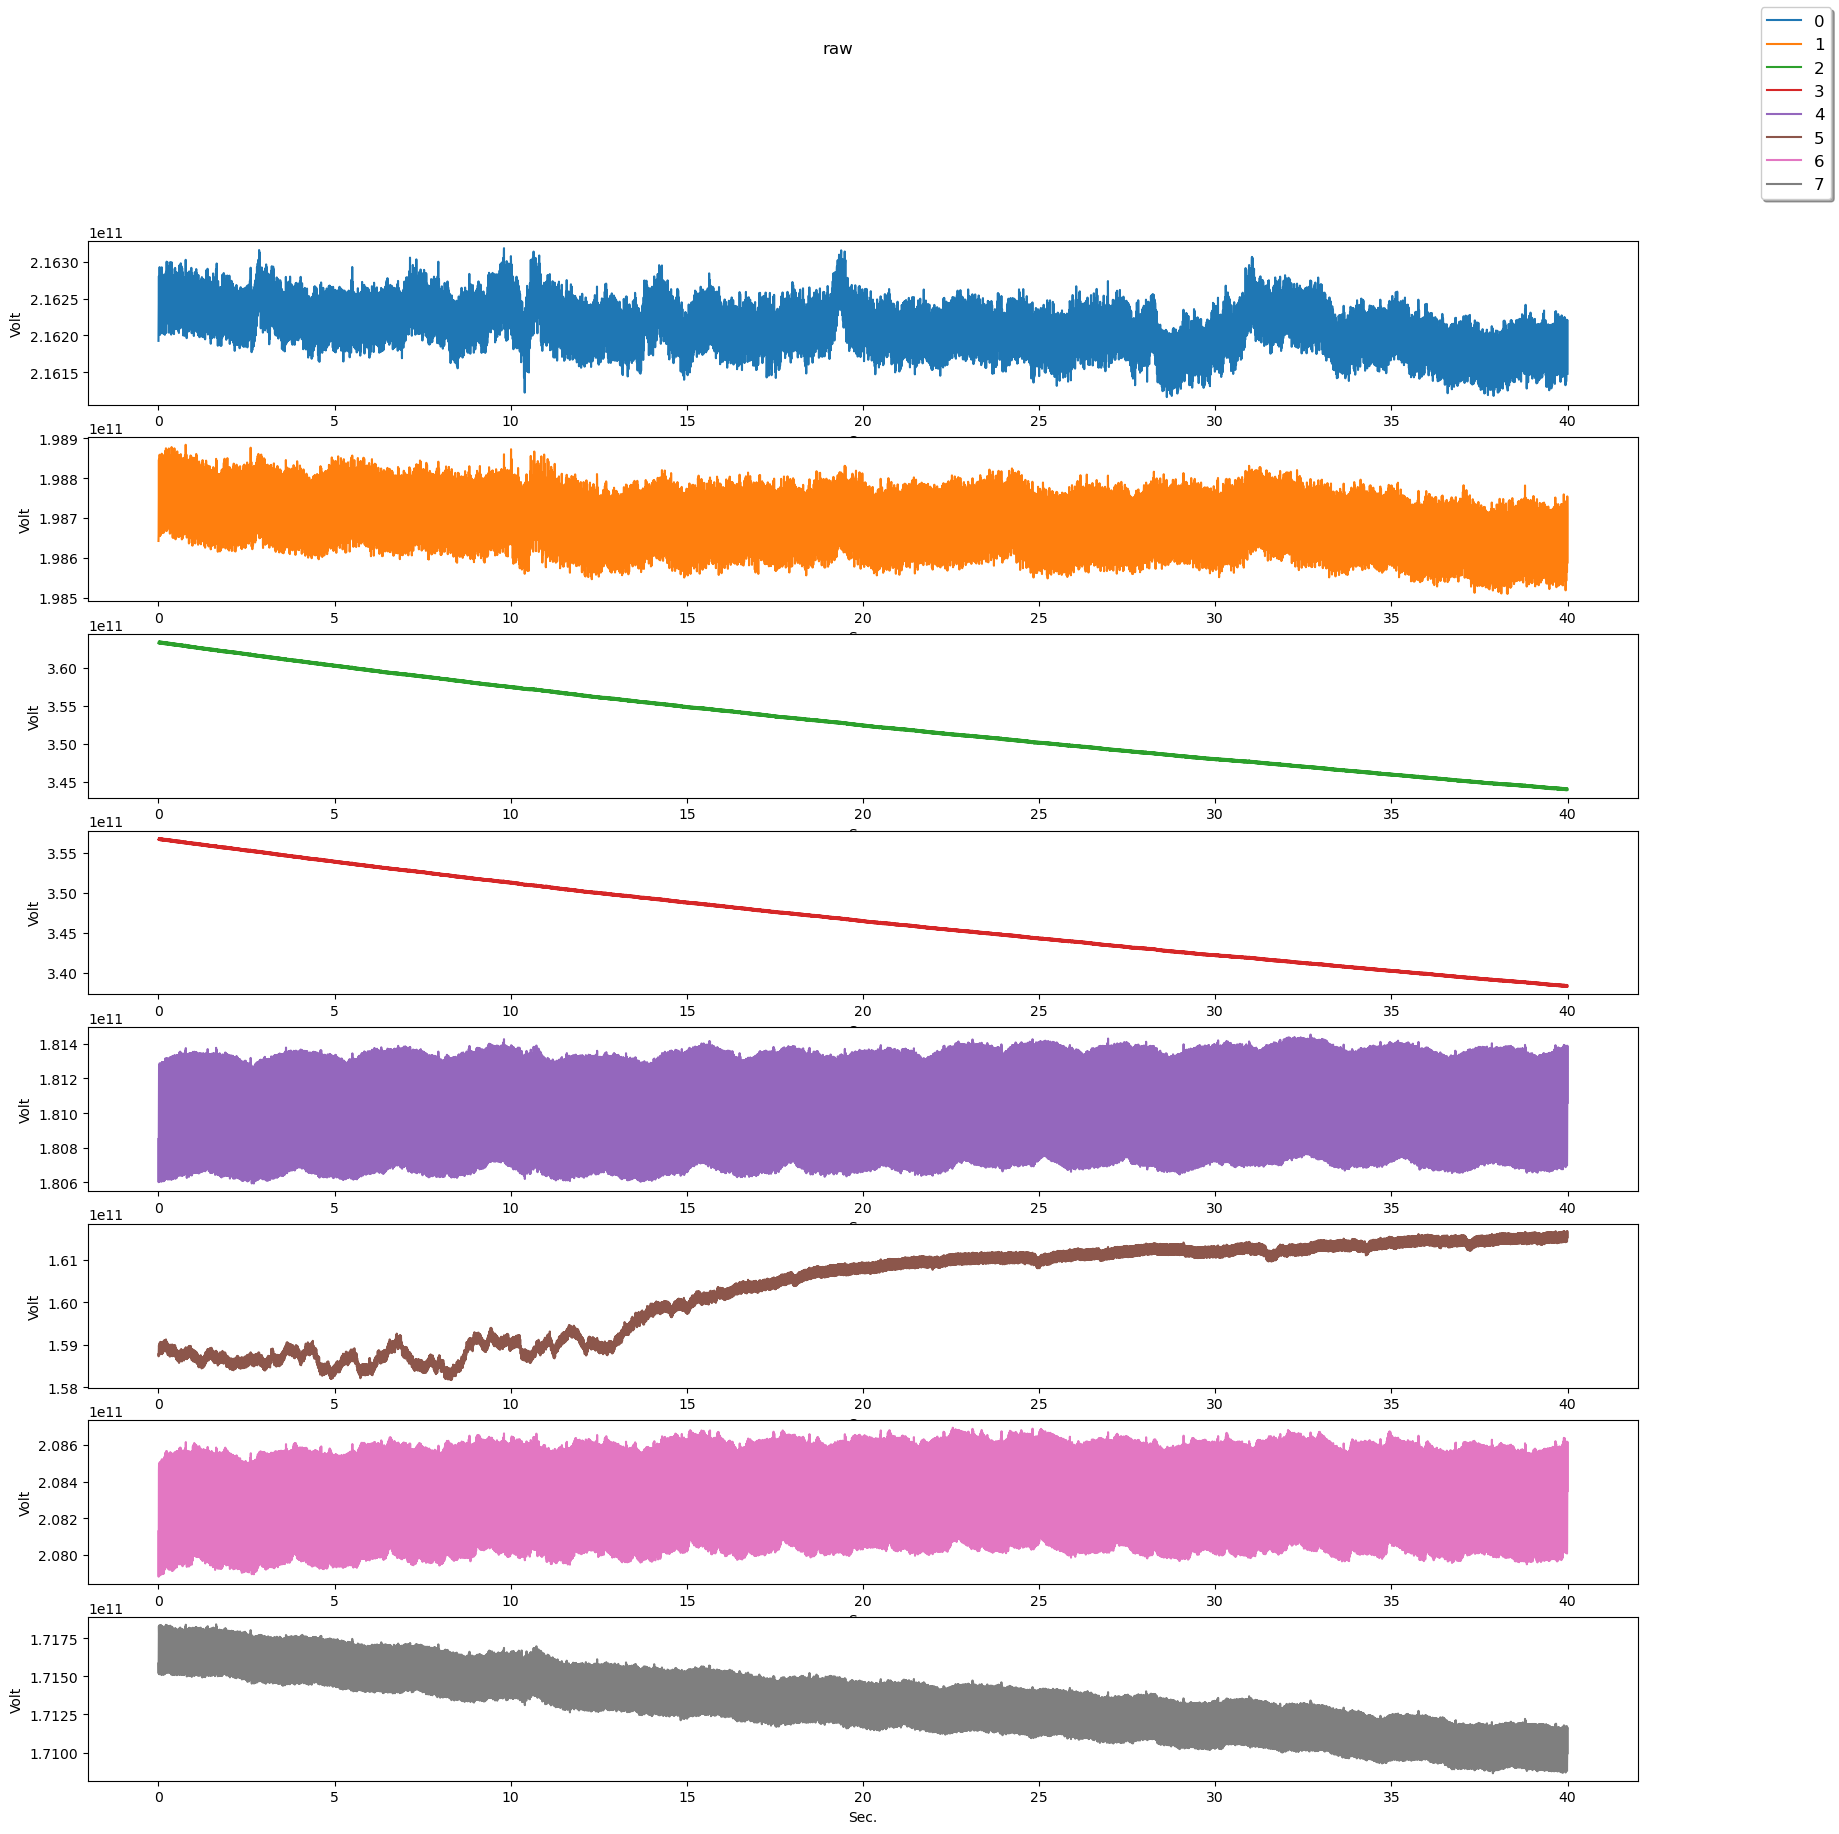

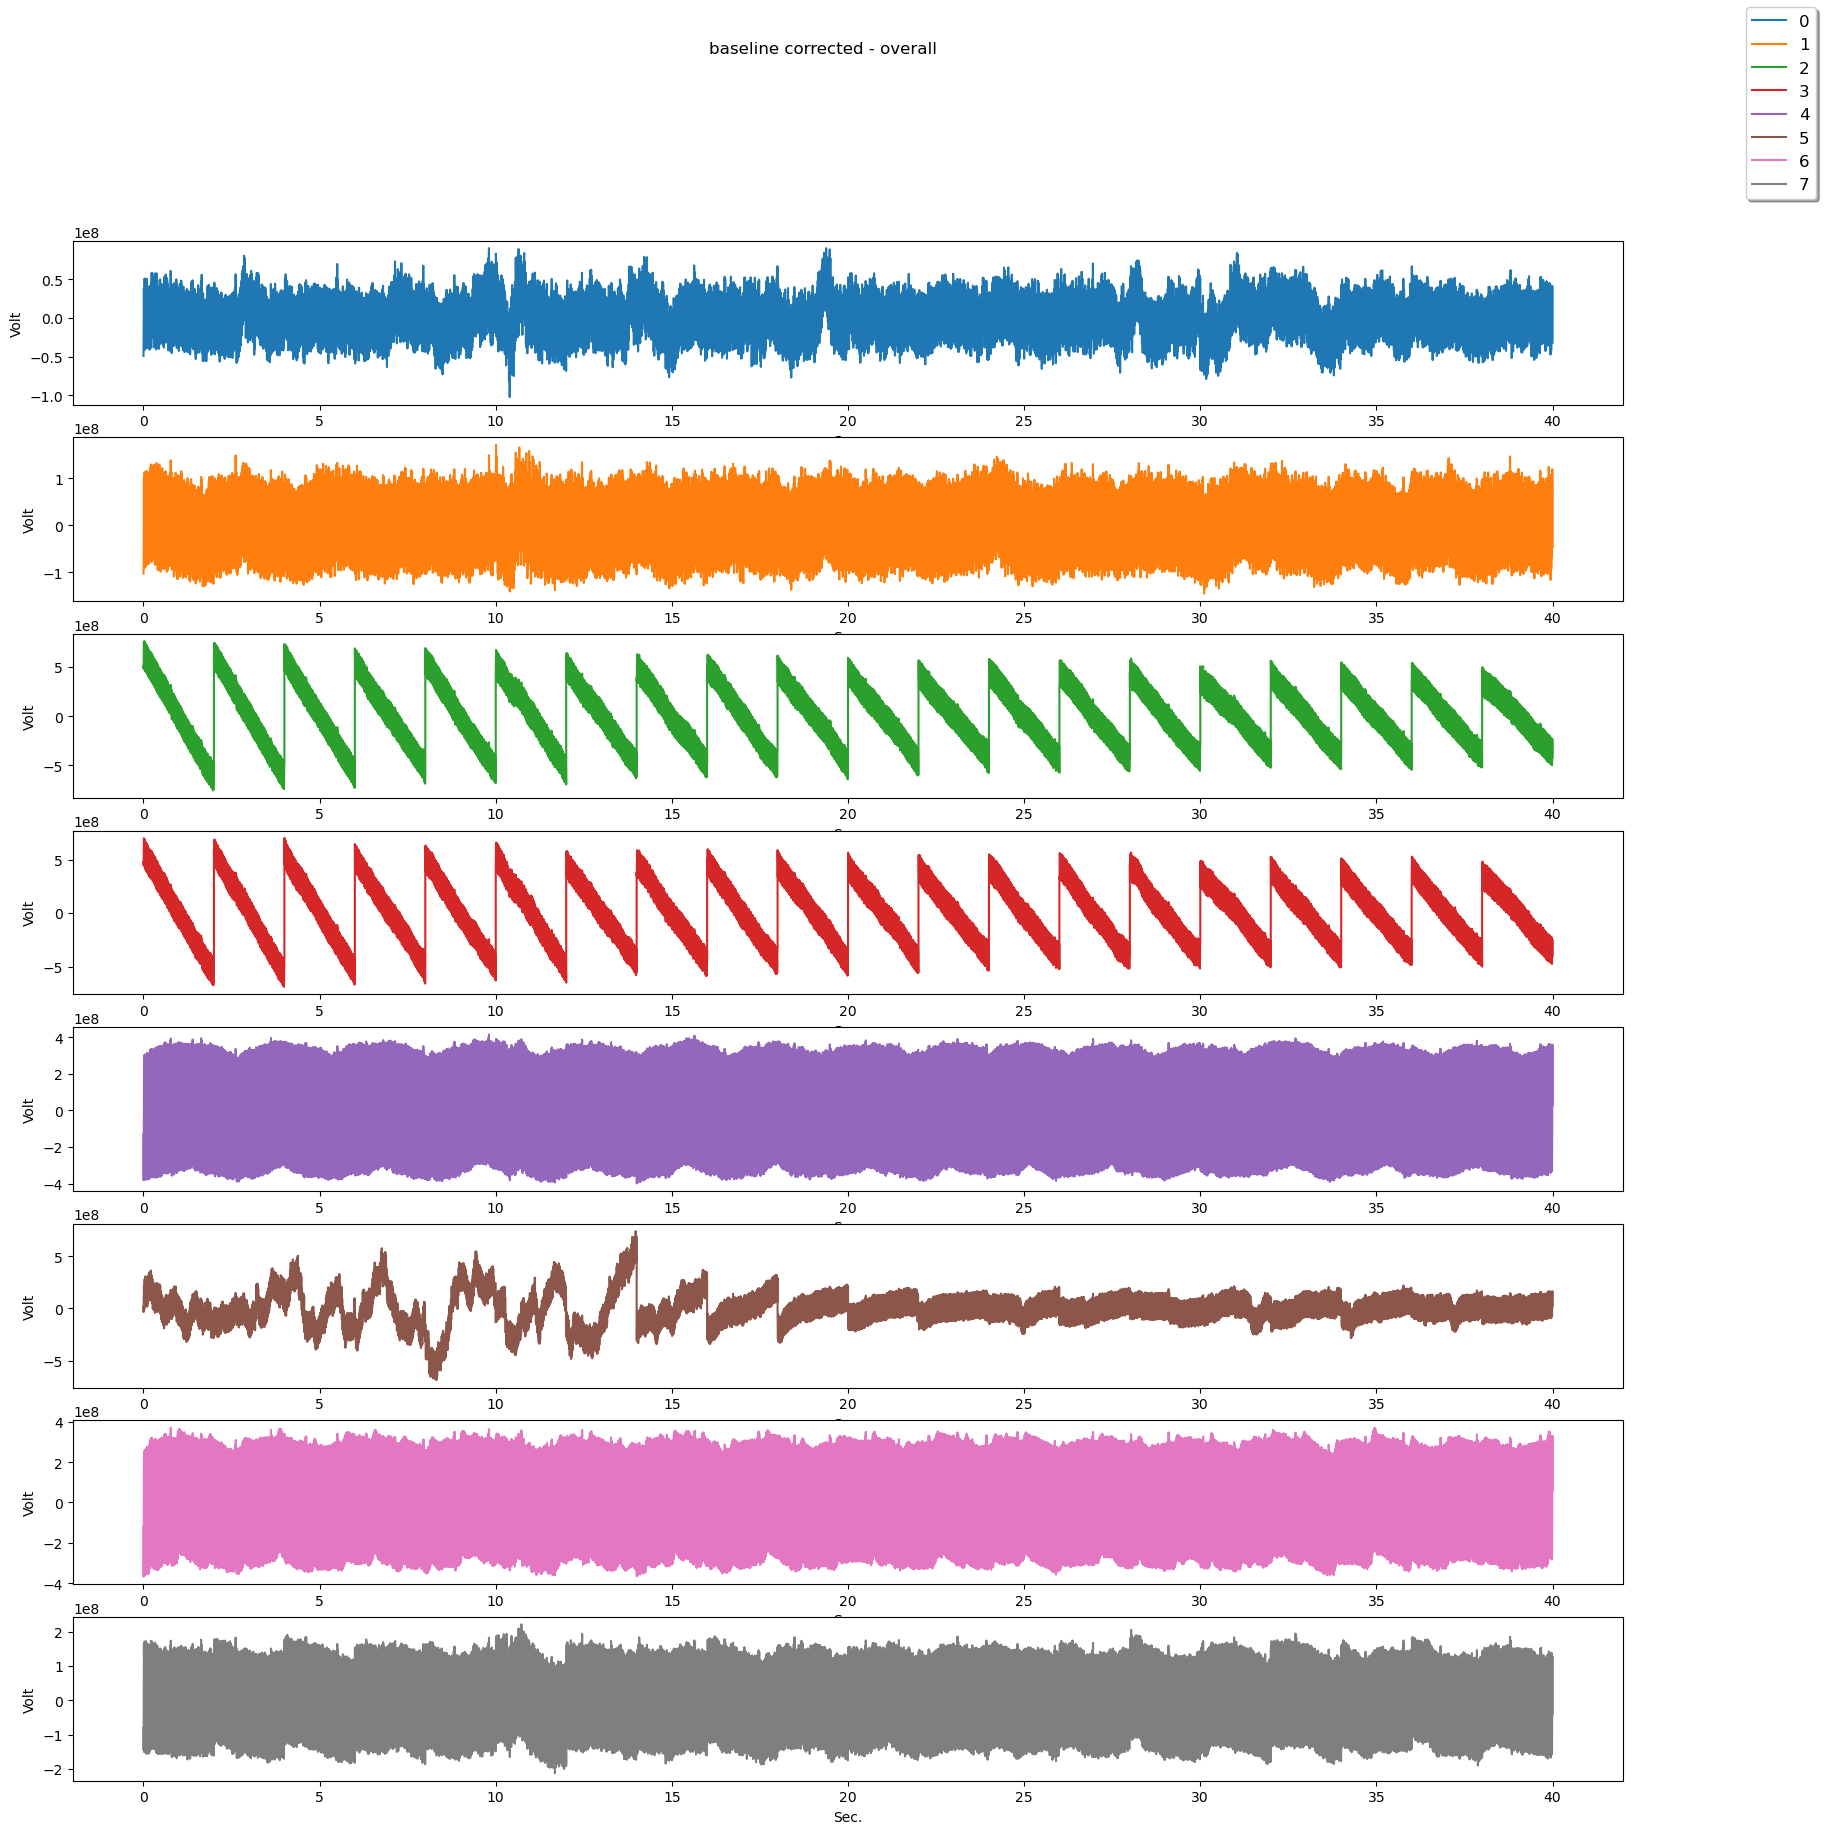

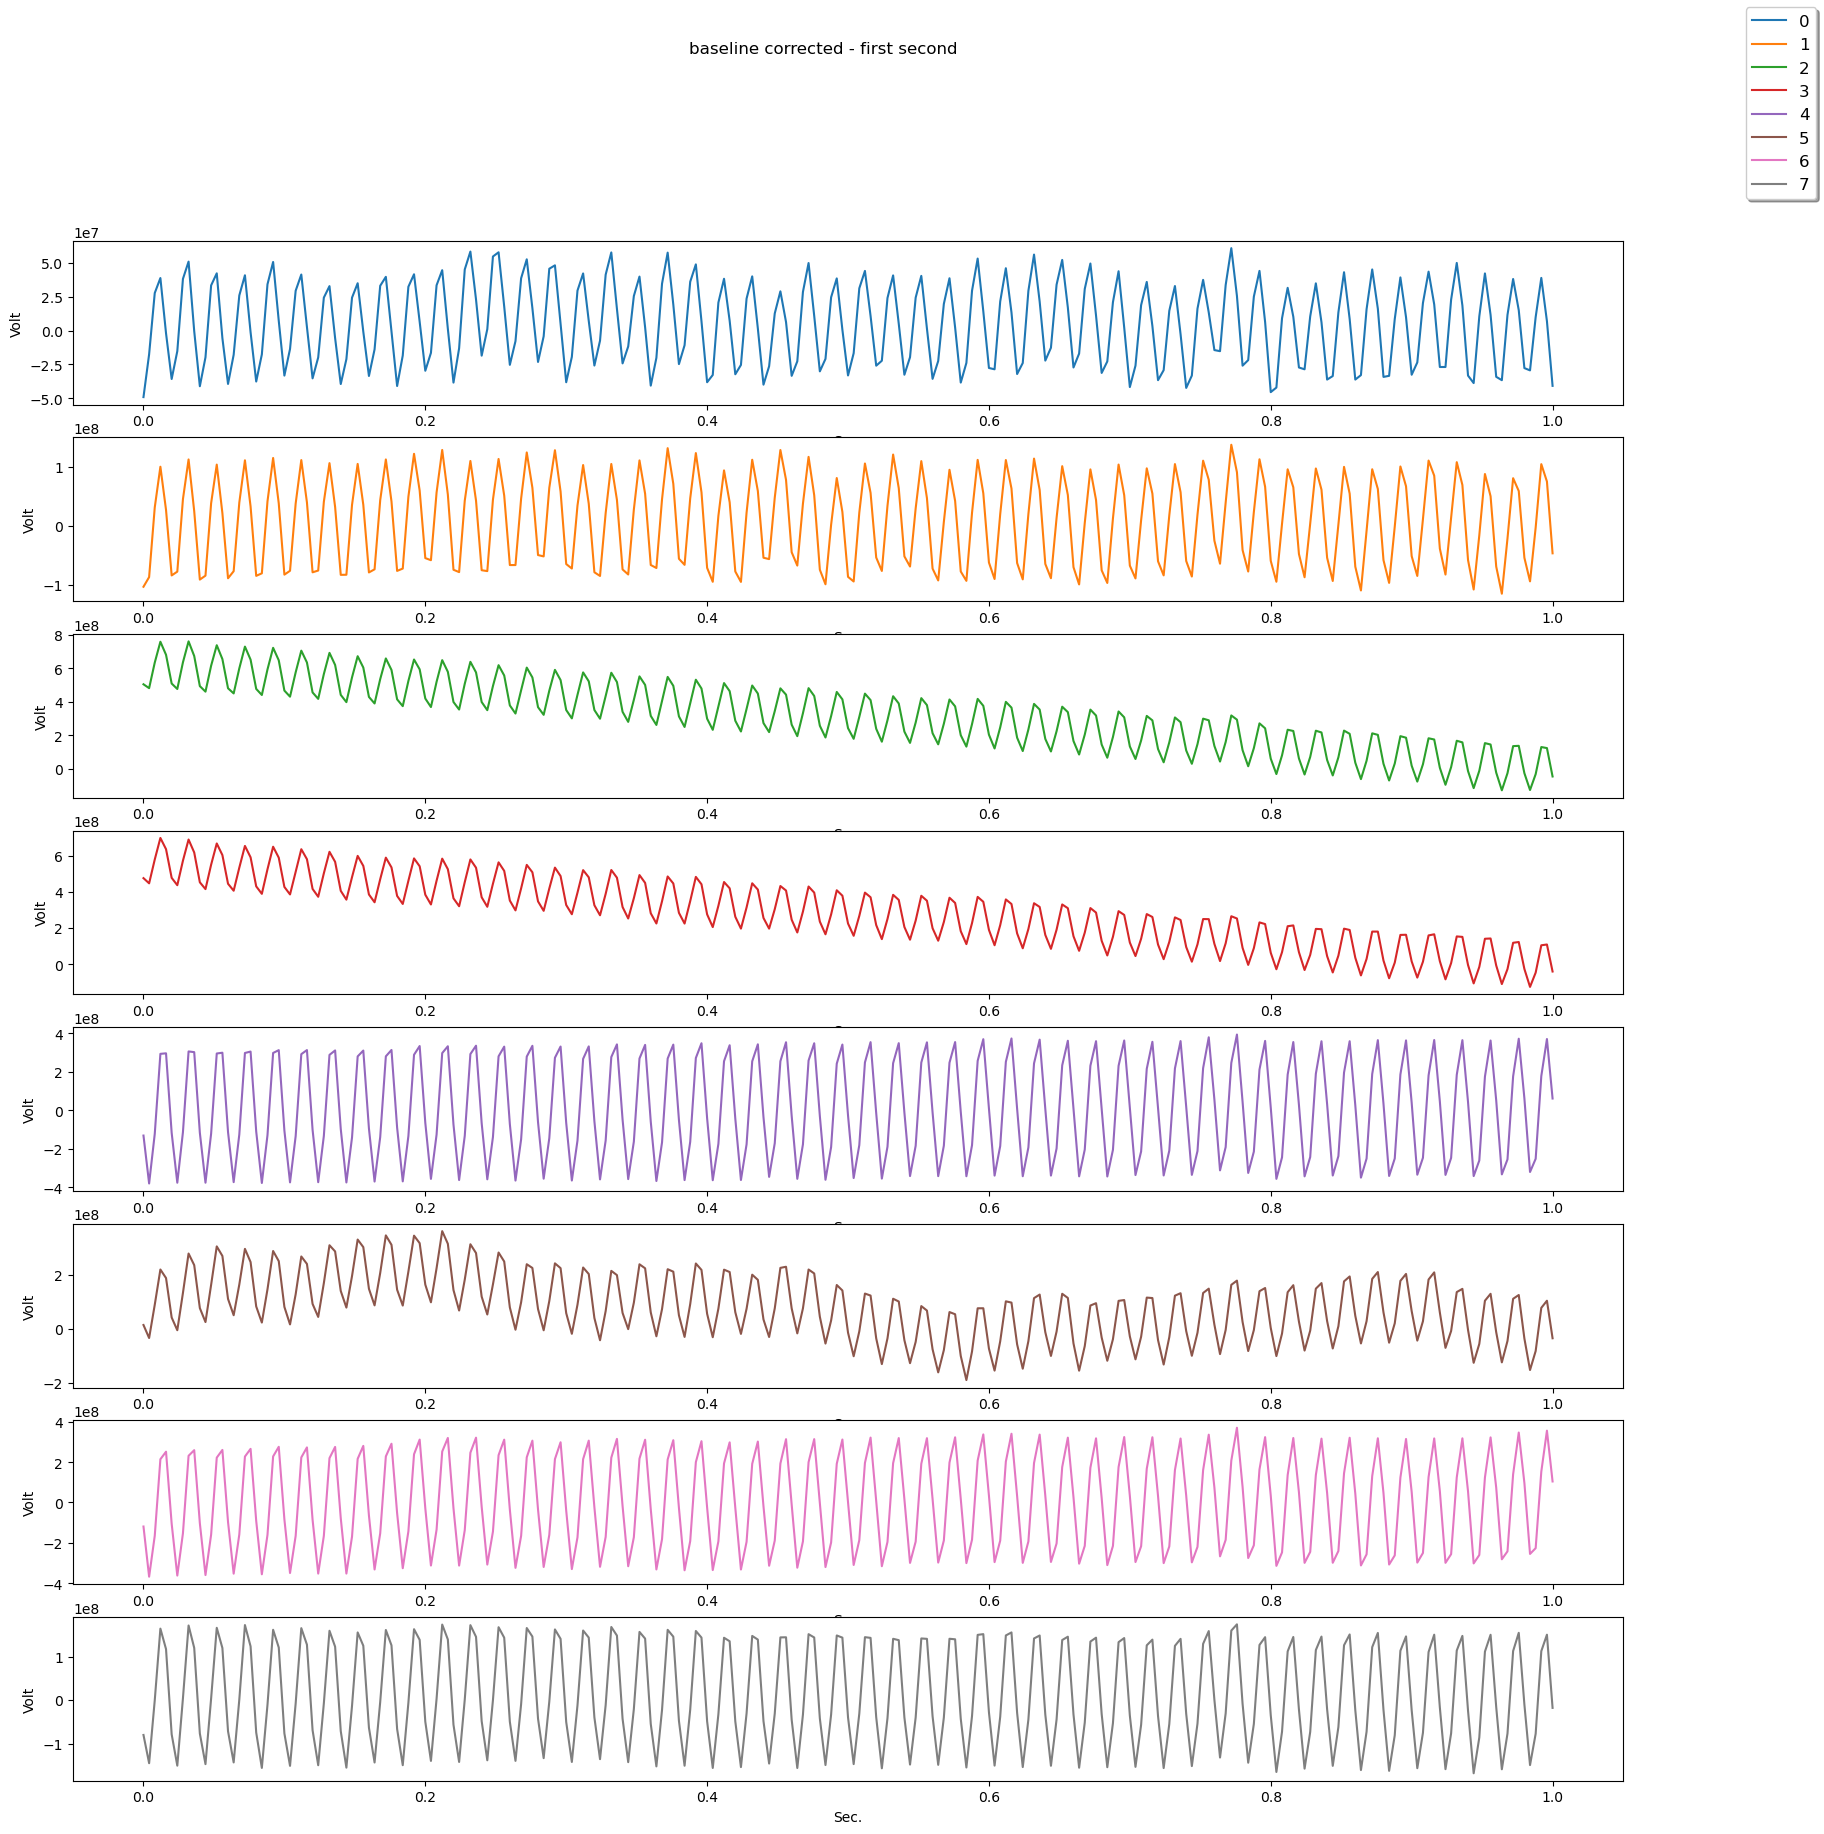

In [11]:
# Baseline correction (BC)
# We perform the correction by converting the data into a vanilla pandas dataframe.
# 
# For general BC info, see https://neuro.inf.unibe.ch/AlgorithmsNeuroscience/Tutorial_files/BaselineCorrection.html

def plotChannel(df: pd.DataFrame, title, tmin=0.0, tmax=40.0):

        fig, ax = plt.subplots(len(df.columns), figsize=(20, 20))

        for i, col in enumerate(df.columns):   
            ax[i].plot(df[(df.index >= tmin) & (df.index <= tmax)][col], label=col, color=[x for x in colors.TABLEAU_COLORS.values()][i])
            ax[i].set_xlabel('Sec.')
            ax[i].set_ylabel('Volt')
        legend = fig.legend(loc='upper right', shadow=True, fontsize='large')
        fig.suptitle(title)
        plt.show()

print("Describe: ", current_baseline_mne_list[0].describe())
df = raw.to_data_frame()
df.set_index('time', inplace=True)
plotChannel(df, 'raw')

bc = []
step = 2
for i in range(0, int(df.index.max()), step):
    tmin = i
    tmax = i+step
    mean = df[(df.index >= tmin) & (df.index <= tmax)].mean()
    bc.append(df[(df.index >= tmin) & (df.index <= tmax)] - mean)
df_bc = pd.concat(bc)

plotChannel(df_bc, 'baseline corrected - overall')
plotChannel(df_bc, 'baseline corrected - first second', 0, 1)

# convert back to RawArray
#info = mne.create_info(8, 250, ["eeg"] * 8)
#test = mne.io.RawArray(df.T, info)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 413 samples (1.652 sec)



/tmp/ipykernel_1626693/1618761179.py:22: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filt.plot_psd(tmax=np.inf, fmin=fmin, fmax=fmax, verbose=False)


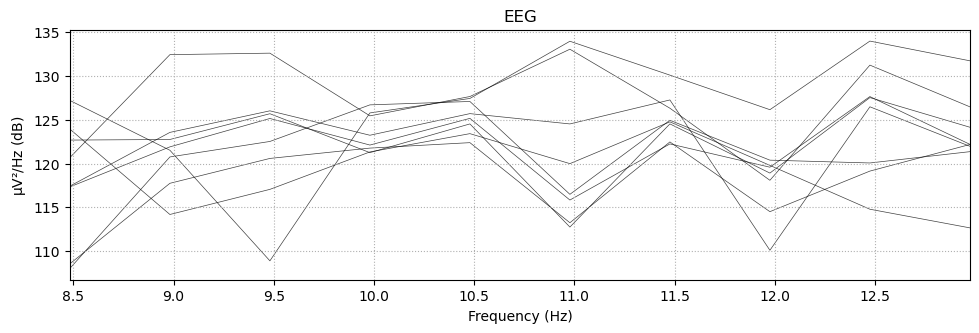

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.50
- Lower transition bandwidth: 3.38 Hz (-6 dB cutoff frequency: 11.81 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 245 samples (0.980 sec)



/tmp/ipykernel_1626693/1618761179.py:22: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filt.plot_psd(tmax=np.inf, fmin=fmin, fmax=fmax, verbose=False)


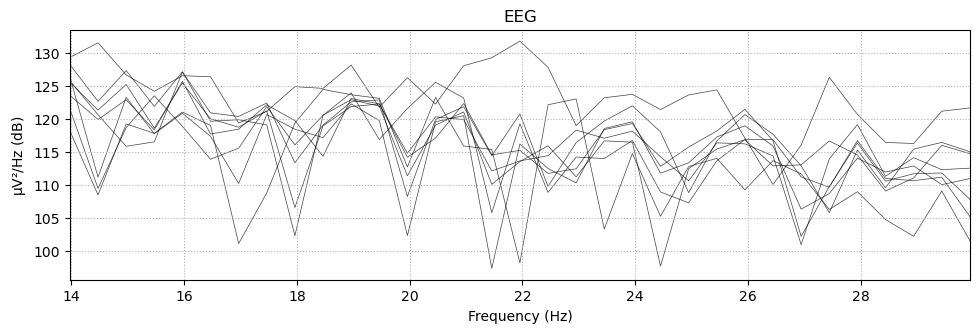

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.50
- Lower transition bandwidth: 7.62 Hz (-6 dB cutoff frequency: 26.69 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 109 samples (0.436 sec)



/tmp/ipykernel_1626693/1618761179.py:22: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filt.plot_psd(tmax=np.inf, fmin=fmin, fmax=fmax, verbose=False)


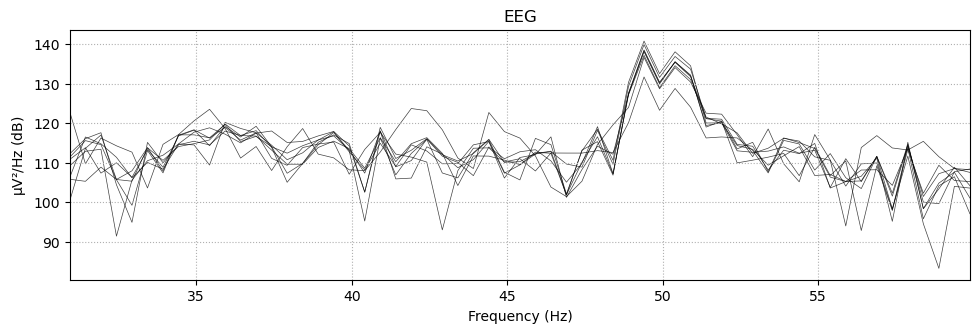

In [12]:
# plot relevant frequency bands

#specify participant
raw = current_baseline_mne_list[0]

# bands taken from slides
FREQ_BANDS = { 
                "alpha": [8, 13],
                "beta": [13.5, 30],
                "gamma": [30.5, 60],
            }

# apply notch filter
freqs = (50, 100)
raw_notch = raw.copy().notch_filter(freqs=freqs, verbose=False, notch_widths=0.5)

raw_crop = raw_notch.copy().crop(tmin=0, tmax=2)
for band, freq in FREQ_BANDS.items():
    fmin, fmax = freq
    raw_filt = raw_crop.copy()
    raw_filt.filter(fmin, fmax, n_jobs=1)
    raw_filt.plot_psd(tmax=np.inf, fmin=fmin, fmax=fmax, verbose=False)

In [13]:
from mne.time_frequency import psd_welch


def eeg_power_band(raw: mne.io.RawArray):
    """EEG relative power band feature extraction.

    This function takes an ``mne.io.RawArray`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    raw : RawArray
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """

    # bands taken from slides
    fmin=8
    fmax=60
    FREQ_BANDS = {
        "alpha": [8, 13],
        "beta": [13.5, 30],
        "gamma": [30.5, 60],
    }

    psds, freqs = psd_welch(raw, picks="eeg", fmin=fmin, fmax=fmax, verbose=False)

    # Normalize the PSDs
    # Baseline in time dimension not neccessary (0th PSD dimension)
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_mean = psds[:, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        psds_min = psds[:, (freqs >= fmin) & (freqs < fmax)].min(axis=-1)
        psds_max = psds[:, (freqs >= fmin) & (freqs < fmax)].max(axis=-1)
        psds_var = psds[:, (freqs >= fmin) & (freqs < fmax)].var(axis=-1)
        # IMPROVEMENT: use statistical features (min, max, var)
        # FURTHER IDEA: use bins (e.g. 2 Hz range)
        X.append(psds_mean.reshape(len(psds), -1))
        X.append(psds_min.reshape(len(psds), -1))
        X.append(psds_max.reshape(len(psds), -1))
        X.append(psds_var.reshape(len(psds), -1))

    return np.concatenate(X, axis=-2).squeeze()  # concatenate all 8 channels * 3 frequences


In [14]:
# show a feature example
tmp = eeg_power_band(trials['ball'][0])
print(tmp.shape)
tmp


(96,)


array([8.74597993e-04, 1.82549110e-04, 7.74885565e-05, 9.38185801e-05,
       1.28019790e-05, 1.05996956e-04, 2.21077568e-05, 5.40367327e-05,
       5.55307982e-04, 1.28915640e-04, 4.91508700e-05, 5.02921846e-05,
       8.30502886e-06, 6.90306136e-05, 1.92200492e-05, 4.66185898e-05,
       1.26573443e-03, 2.67661442e-04, 9.20242270e-05, 1.31451955e-04,
       1.56757868e-05, 1.33512306e-04, 2.85408828e-05, 5.87103110e-05,
       8.10927164e-08, 3.05241628e-09, 2.22146202e-10, 8.85972838e-10,
       6.03486513e-12, 5.19414199e-10, 1.16846909e-11, 2.08502605e-11,
       3.42693211e-04, 6.18314436e-05, 3.61599254e-05, 3.81126667e-05,
       6.50428582e-06, 4.33669275e-05, 9.05006646e-06, 2.86779680e-05,
       2.04970120e-04, 2.86427253e-05, 1.37532943e-05, 2.05013453e-05,
       2.64919467e-06, 1.83128801e-05, 2.60086765e-06, 1.17177243e-05,
       5.51854337e-04, 1.07615810e-04, 7.51703670e-05, 6.22226339e-05,
       1.28799263e-05, 8.57171655e-05, 2.26774997e-05, 5.47323160e-05,
      

In [16]:
# create feature and class arrays

def create_ml_data(trails, step=2):
    X = []
    y = []
    for data_class, data_list in trails.items():
        for raw in data_list:

            # apply notch filter
            freqs = (50, 100)
            raw_notch = raw.copy().notch_filter(freqs=freqs, verbose=False, notch_widths=0.5)

            # slice and create psd
            for start in range(0, int(raw.tmax), step):
                raw_crop = raw_notch.copy().crop(tmin=start, tmax=start+step)
                X.append(eeg_power_band(raw_crop))
                y.append(data_class)

    return X, y

X, y = create_ml_data(trials)

print(X[:1], len(X)) # 8 channels * 5 values
print(y[:1], len(y))


[array([7.28744991e-02, 4.50944180e-02, 1.02333470e-02, 3.09393872e-02,
       1.03141196e-03, 1.14623127e-02, 1.30605808e-03, 1.16824083e-02,
       2.03175932e-02, 8.55511095e-03, 3.80826685e-03, 5.70391109e-03,
       5.19539438e-04, 9.81533485e-03, 8.66524289e-04, 8.68257846e-03,
       2.13488214e-01, 7.78620505e-02, 1.59630794e-02, 7.17179187e-02,
       1.59122830e-03, 1.47156372e-02, 2.34486795e-03, 1.40240811e-02,
       5.22631688e-03, 7.49879050e-04, 1.69391856e-05, 5.13903769e-04,
       1.27064852e-07, 3.25389755e-06, 2.85683106e-07, 3.65886834e-06,
       2.30067317e-02, 1.46953901e-02, 4.41285410e-03, 9.00720226e-03,
       6.47273984e-04, 8.68804609e-03, 6.65157271e-04, 5.97830247e-03,
       3.65289568e-03, 2.03166172e-03, 1.68015795e-04, 1.83582065e-03,
       5.19308890e-05, 9.25436628e-04, 5.37123170e-05, 6.20122011e-04,
       4.33039763e-02, 3.65646356e-02, 1.11151961e-02, 1.76450154e-02,
       1.56834807e-03, 2.43811594e-02, 2.09770215e-03, 1.79662041e-02,
     

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
clf.fit(X_train, y_train)

# Test
y_pred = clf.predict(X_test)

# Assess the results
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
print(classification_report(y_test, y_pred, target_names=trials.keys()))
print(confusion_matrix(y_test, y_pred))

Accuracy score: 0.5
                   precision    recall  f1-score   support

             ball       0.39      0.58      0.47        12
      ball+number       0.64      0.53      0.58        17
ball+number+wheel       0.42      0.29      0.34        17
         baseline       0.67      1.00      0.80         4

         accuracy                           0.50        50
        macro avg       0.53      0.60      0.55        50
     weighted avg       0.51      0.50      0.49        50

[[7 2 2 1]
 [2 9 5 1]
 [9 3 5 0]
 [0 0 0 4]]


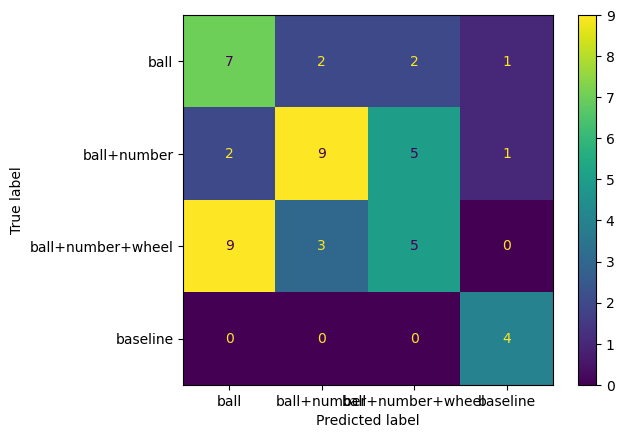

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [24]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(SVC(kernel= 'linear', random_state=42, C=0.1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
pipe.fit(X_train, y_train)

# Test
y_pred = pipe.predict(X_test)

# Assess the results
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
print(classification_report(y_test, y_pred, target_names=trials.keys()))
print(confusion_matrix(y_test, y_pred))

Accuracy score: 0.24
                   precision    recall  f1-score   support

             ball       0.24      1.00      0.39        12
      ball+number       0.00      0.00      0.00        17
ball+number+wheel       0.00      0.00      0.00        17
         baseline       0.00      0.00      0.00         4

         accuracy                           0.24        50
        macro avg       0.06      0.25      0.10        50
     weighted avg       0.06      0.24      0.09        50

[[12  0  0  0]
 [17  0  0  0]
 [17  0  0  0]
 [ 4  0  0  0]]


/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
from sklearn.ensemble import GradientBoostingClassifier

pipe = make_pipeline(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
pipe.fit(X_train, y_train)

# Test
y_pred = pipe.predict(X_test)

# Assess the results
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
print(classification_report(y_test, y_pred, target_names=trials.keys()))
print(confusion_matrix(y_test, y_pred))

Accuracy score: 0.44
                   precision    recall  f1-score   support

             ball       0.46      0.50      0.48        12
      ball+number       0.47      0.41      0.44        17
ball+number+wheel       0.41      0.41      0.41        17
         baseline       0.40      0.50      0.44         4

         accuracy                           0.44        50
        macro avg       0.43      0.46      0.44        50
     weighted avg       0.44      0.44      0.44        50

[[6 2 3 1]
 [1 7 7 2]
 [6 4 7 0]
 [0 2 0 2]]


In [26]:
import xgboost as xgb
from sklearn.model_selection import  GridSearchCV, StratifiedKFold

estimator = xgb.sklearn.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='logloss',
    # tree_method="gpu_hist", # no gpu present
    )

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(y)
y_numeric

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, random_state=42)

# Train
estimator.fit(X_train, y_train)

# Test
y_pred = estimator.predict(X_test)

# Assess the results
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
print(classification_report(y_test, y_pred, target_names=trials.keys()))
print(confusion_matrix(y_test, y_pred))

Accuracy score: 0.44
                   precision    recall  f1-score   support

             ball       0.27      0.33      0.30        12
      ball+number       0.60      0.71      0.65        17
ball+number+wheel       0.22      0.12      0.15        17
         baseline       0.67      1.00      0.80         4

         accuracy                           0.44        50
        macro avg       0.44      0.54      0.47        50
     weighted avg       0.40      0.44      0.41        50

[[ 4  4  4  0]
 [ 0 12  3  2]
 [11  4  2  0]
 [ 0  0  0  4]]


In [28]:
# find good parameters
# we limit this as we have limited ressources (time and hardware)

import xgboost as xgb
from sklearn.model_selection import  GridSearchCV, StratifiedKFold

estimator = xgb.sklearn.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='logloss',
    # tree_method="gpu_hist", # no gpu present
    )

param_grid = {
    'learning_rate': [.1, 0.2, 0.4],  # `eta` value
    #'max_depth': [4, 6, 8],
    #'min_child_weight': [1, 3, 5, 10],
    #'subsample': [0.7, 1],
    #'colsample_bytree': [0.7, 1],
    'n_estimators': [10, 20, 50, 100],
    #'gamma': [0.5, 1, 2]
}

mycv = StratifiedKFold(n_splits=10)

grid = GridSearchCV(
    estimator,
    param_grid,
    refit='accuracy',
    verbose=1,
    scoring=['accuracy'],
    cv=mycv
)


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(y)

grid.fit(X, y_numeric) # takes too long

print(grid.best_params_)
print(grid.best_score_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'learning_rate': 0.4, 'n_estimators': 10}
0.5000000000000001


In [29]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
import re

estimator = RandomForestClassifier(n_estimators=100, random_state=42)

param_grid = {
    "n_estimators": [100], #takes too long for big n of estimators, e.g. 1000!
}

mycv = StratifiedKFold(n_splits=10)

grid = GridSearchCV(
    estimator,
    param_grid,
    refit='accuracy',
    verbose=1,
    scoring=['accuracy'],
    cv=mycv
)

le = LabelEncoder()

# make predictions for all participants individually
for i, current in enumerate(baseline_list):
    current_baseline_list = [current]
    current_experiment_list = [experiment_list[i]]
    participant = re.findall(r"sub-(\w*)_ses", current_baseline_list[0])[0]

    trials = read_trails(current_experiment_list, current_baseline_list)
    X, y = create_ml_data(trials)

    y_numeric = le.fit_transform(y)
    grid.fit(X, y_numeric)
    print(f'best accuracy for {participant} : {round(grid.best_score_, 2)}') # Mean cross-validated score of the best_estimator

# make predictions for all participants collectively
current_baseline_list = baseline_list
current_experiment_list = experiment_list

trials = read_trails(current_experiment_list, current_baseline_list)
X, y = create_ml_data(trials)

y_numeric = le.fit_transform(y)
grid.fit(X, y_numeric)
print(f'mean accuracy for all participants : {round(grid.best_score_, 2)}')


Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Tobias : 0.46
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Karla : 0.37
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Jonah : 0.45
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Hussan : 0.38
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Gaffar : 0.38
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Christian : 0.46
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Aljoscha : 0.42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Oskar : 0.55
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Timo : 0.37
Fitting 10 folds for each of 1 candidates, totalling 10 fits
mean accuracy for all participants : 0.32


In [30]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
import re

estimator = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=42)

param_grid = {
    "learning_rate": [0.2],
    "n_estimators": [100], #takes too long for big n of estimators, e.g. 1000!
}

mycv = StratifiedKFold(n_splits=10)

grid = GridSearchCV(
    estimator,
    param_grid,
    refit='accuracy',
    verbose=1,
    scoring=['accuracy'],
    cv=mycv
)

le = LabelEncoder()

# make predictions for all participants individually
for i, current in enumerate(baseline_list):
    current_baseline_list = [current]
    current_experiment_list = [experiment_list[i]]
    participant = re.findall(r"sub-(\w*)_ses", current_baseline_list[0])[0]

    trials = read_trails(current_experiment_list, current_baseline_list)
    X, y = create_ml_data(trials)

    y_numeric = le.fit_transform(y)
    grid.fit(X, y_numeric)
    print(f'best accuracy for {participant} : {round(grid.best_score_, 2)}') # Mean cross-validated score of the best_estimator

# make predictions for all participants collectively
current_baseline_list = baseline_list
current_experiment_list = experiment_list

trials = read_trails(current_experiment_list, current_baseline_list)
X, y = create_ml_data(trials)

y_numeric = le.fit_transform(y)
grid.fit(X, y_numeric)
print(f'mean accuracy for all participants : {round(grid.best_score_, 2)}')


Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Tobias : 0.42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Karla : 0.4
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Jonah : 0.44
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Hussan : 0.4
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Gaffar : 0.38
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Christian : 0.42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Aljoscha : 0.36
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Oskar : 0.53
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Timo : 0.34
Fitting 10 folds for each of 1 candidates, totalling 10 fits
mean accuracy for all participants : 0.36


<class 'list'>
(150, 96)


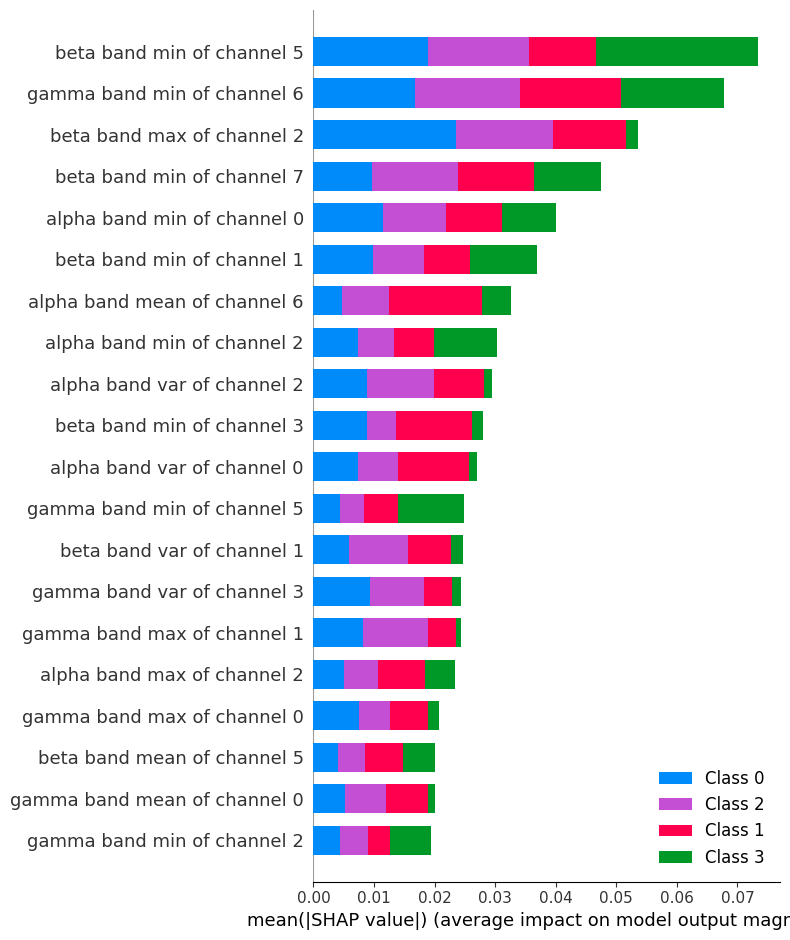

In [74]:
# Feature importance
# Compute the SHAP values for the model
import shap 

# Create feature name list
from itertools import product

feature_labels = list()
for channel, band  in product(range(8), ['alpha', 'beta', 'gamma']):
    feature_labels += [f'{band} band mean of channel {channel}', f'{band} band min of channel {channel}', f'{band} band max of channel {channel}', f'{band} band var of channel {channel}']

# Load data for first participant
trials = read_trails([current_experiment_list[0]], [current_baseline_list[0]])
X, y = create_ml_data(trials)

# Refit random forest clf and make prediction
clf = RandomForestClassifier(n_estimators=100, random_state=42)
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Train
clf.fit(X_train, y_train)

print(type(X_train))
samples = np.array(X_train)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)
print(shap_values[0].shape)
shap.summary_plot(shap_values, feature_names=feature_labels)


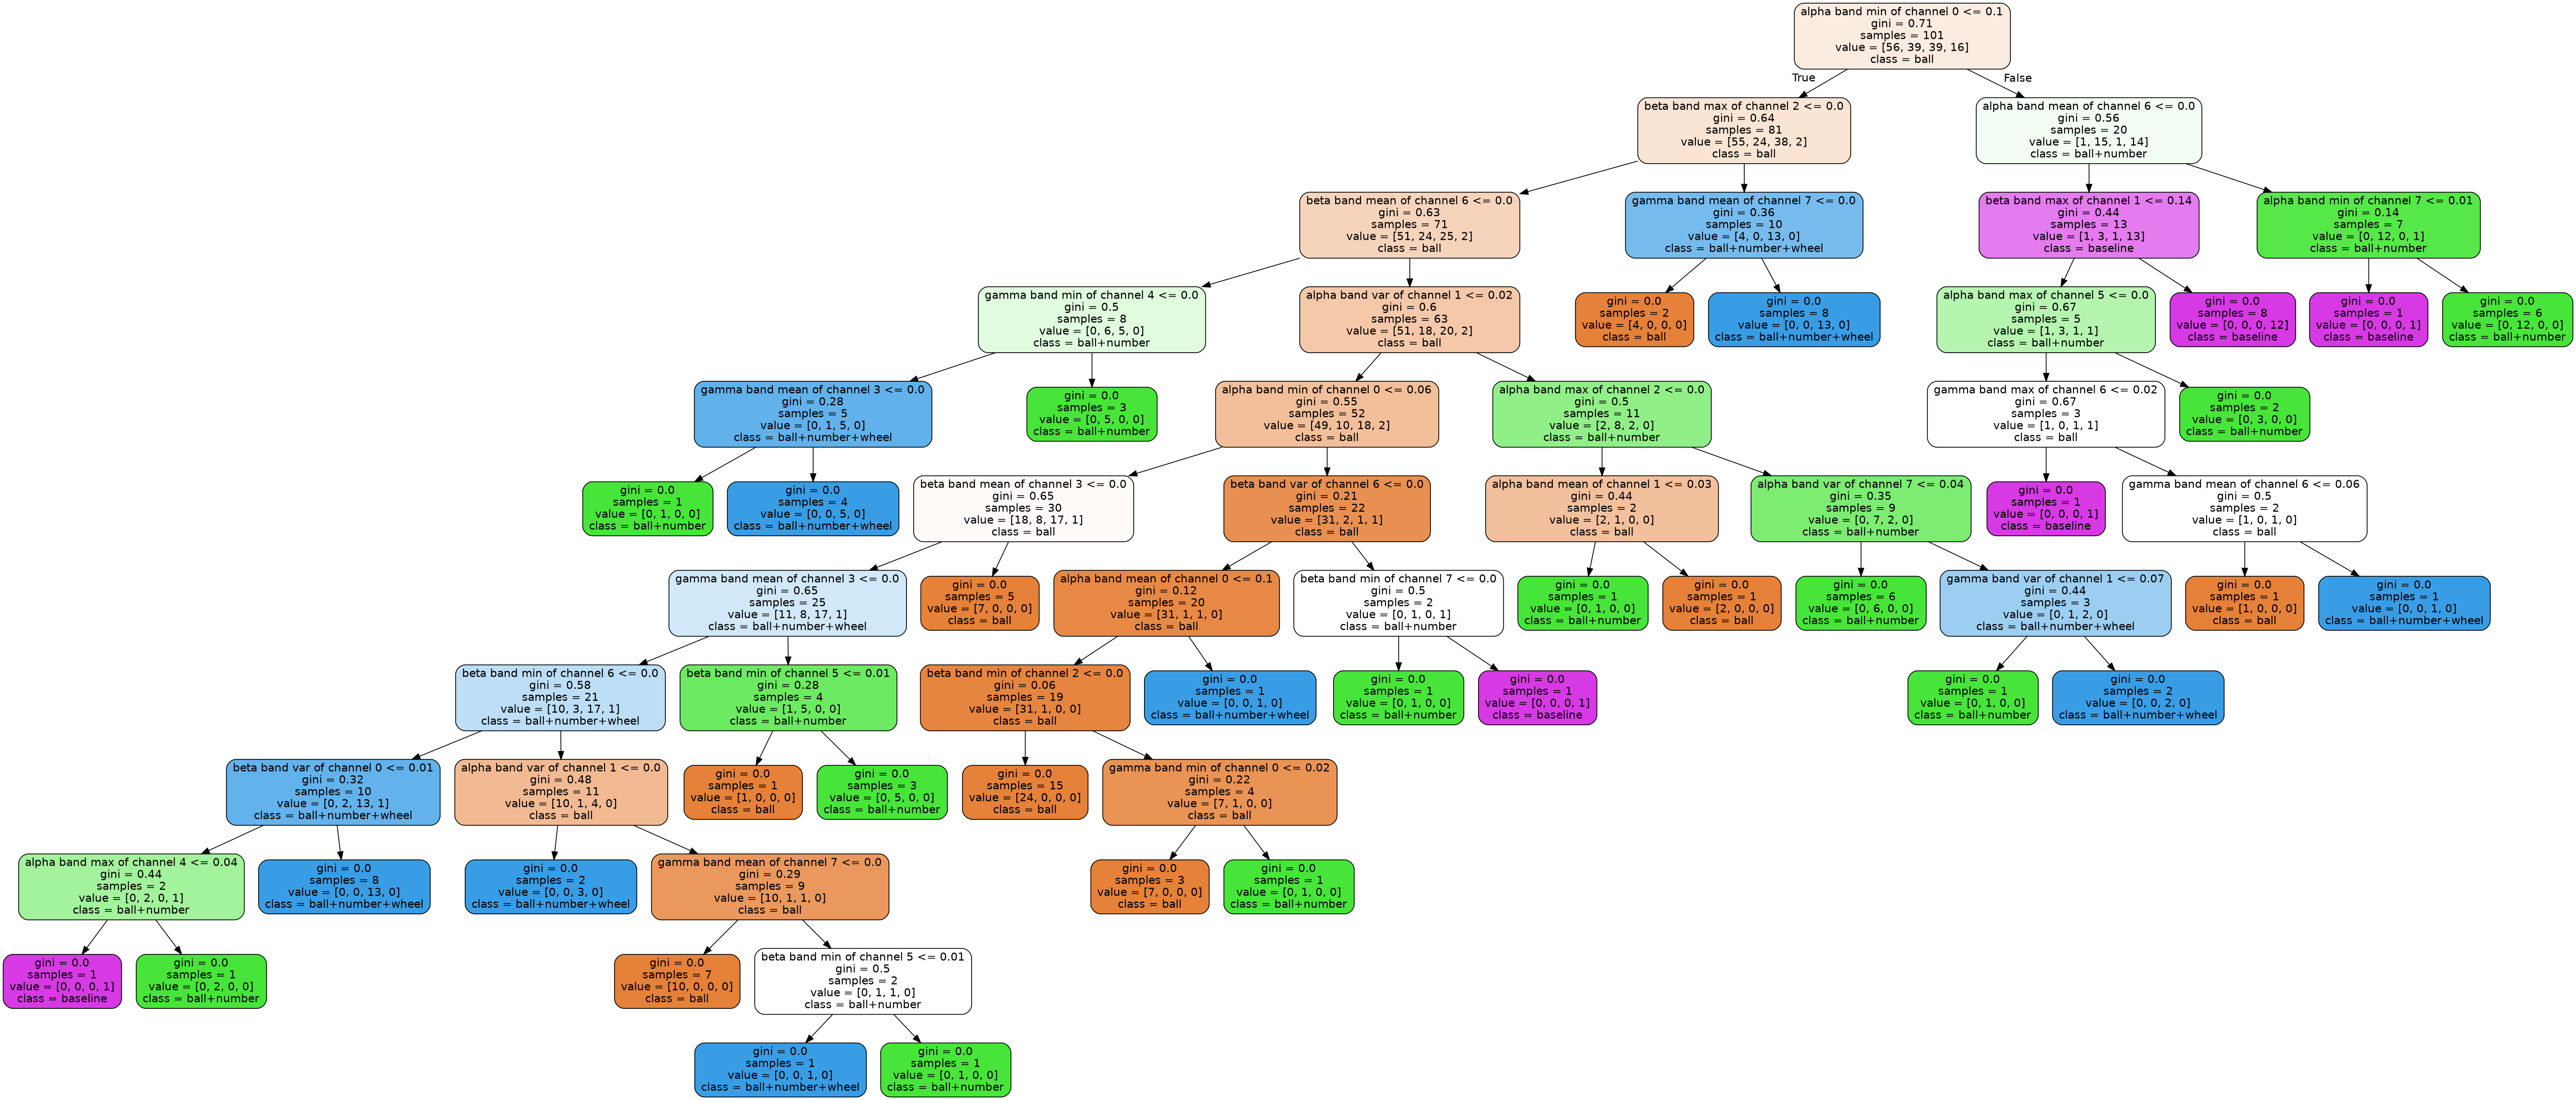

In [79]:
# visualize one of the decision trees
from sklearn.tree import export_graphviz

class_names = ['ball', 'ball+number', 'ball+number+wheel', 'baseline']

# Export as dot file
tree = clf.estimators_[0]
export_graphviz(tree, out_file='tree.dot', 
                feature_names = feature_labels,
                class_names = class_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=150'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')